# The Beginning

we need the following libraries installed:

* `numpy`: to manipulate in vector array
* `vaex`: to open and manipulate big data in dataframe
* `astroquery`: to query Gaia DR3 and other catalogs

In [1]:
import numpy as np
import vaex
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import Tap

from datetime import datetime
from os.path import join, abspath
from glob import glob
import sys
from enum import Enum

There are also many utilities functions in `utils.py` that we will use.
Please be mindful.

In [2]:
current = abspath('')
root_dir = abspath(join(current, ".."))
# add root_dir path to sys.path
# to import modules from the root directory
if not root_dir in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/1_Collecting_Data',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

# Utility Functions

In [3]:
import signal

class TimeoutError(Exception):
    pass

def timeout(func, duration, args=()):
    """
    Run a function with a time limit.

    Args:
        func (function): The function to run.
        duration (int): The maximum number of seconds to allow the function to run.
        args (tuple): The positional arguments to pass to the function. Defaults to an empty tuple.

    Returns:
        dict: A dictionary containing the results of the function call, or an error message if the function timed out or raised an exception.
        The dictionary has two keys:
            - "data": If the function completed successfully, this key maps to the return value of the function.
              If the function failed or timed out, this key maps to None.
            - "error": If the function failed or timed out, this key maps to a dictionary containing information about the error.
              The dictionary has two keys: "type" (a string with the name of the exception) and "message" (a string with the error message).

    Raises:
        TimeoutError: If the function takes longer than `duration` seconds to complete.

    Example usage:
        result = timeout(launch_job, 10, args=(arg1, arg2))
        if result["error"]:
            print("Error:", result["error"]["type"], result["error"]["message"])
        else:
            print("Result:", result["data"])
    """
    def handler(signum, frame):
        raise TimeoutError("Function timed out")

    # Set the signal handler for SIGALRM
    signal.signal(signal.SIGALRM, handler)
    signal.alarm(duration)

    try:
        result = func(*args)
        data = result
        error = None
    except TimeoutError:
        data = None
        error = {"type": "TimeoutError", "message": "Function timed out"}
    except Exception as e:
        data = None
        error = {"type": type(e).__name__, "message": str(e)}

    # Disable the alarm
    signal.alarm(0)

    return {"data": data, "error": error}

In [4]:
def launch_job(job_func, query, cols="", duration=10):
    """
    Launch a job with a timeout.

    Args:
        job_func (func): The job to launch.
        query (str): The query to run.
        cols (str): Rename the cols name if needed.
        duration (int): The timeout duration.

    Returns:
        df (vaex.dataframe): The dataframe or None.
    """
    # run the job and wrap in timeout
    job = timeout(job_func, args=(query,), duration=duration)
    res = { "data": None, "error": None }
    # print error if job failed
    if job['data'] == None:
        res["error"] = job['error']
    # convert the result into vaex.dataframe if successful
    else:
        result = job['data'].get_results()
        df = result.to_pandas()
        if cols != "":
            df.columns = cols
        df = vaex.from_pandas(df)
        res["data"] = df
    return res

In [5]:
def append_name(element, name):
    """
    Append a table name to a column name.
    
    Parameters:
    ----------
    element: str 
        The column name.
    name: str 
        The table name.

    Returns:
    -------
        str: The column name with the table name appended.
    
    Example usage:
    --------------
        [in]:  append_name("id", "users")

        [out]: users.\"id\"

        [in]:  append_name("id AS user_id", "users")

        [out]: users.\"id\" AS user_id
    """
    string = element.split(" AS ")
    if(len(string) == 1):
        return f"{name}.\"{element}\""
    else:
        return f"{name}.\"{string[0]}\" AS {string[1]}"

In [6]:
from utils import safe_mkdir, delete_directory

In [7]:
# get the root of data directory
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [8]:
# Create a directory for Gaia DR3 and 2MASS data
# or if it already exists, just move on
ra_name = "Gaia-2MASS"
gaia_data_dir = join(root_data_dir, ra_name)
safe_mkdir(gaia_data_dir)

Directory /home2/s20321005/Thesis-Project/Data/Gaia-2MASS already exist. Good to go!


In [9]:
# Do the same for 2MASS data
ra_name = "2MASS"
tmass_data_dir = join(root_data_dir, ra_name)
safe_mkdir(tmass_data_dir)

Directory /home2/s20321005/Thesis-Project/Data/2MASS already exist. Good to go!


### defining columns

there are many columns and tables in Gaia DR3 that we need.

gaiadr3.gaia_source AS gdr3:
| Name | Description | Unit |
| --- | --- | --- |
| source_id | unique source identifier | - |
| ra | right ascension | deg |
| dec | declination | deg |
| pmra | proper motion in right ascension (already corrected for declination) | mas/yr |
| pmdec | proper motion in declination | mas/yr |
| pmra_error (e_pmra) | error of proper motion in right ascension | mas/yr |
| pmdec_error (e_pmdec) | error of proper motion in declination | mas/yr |
| parallax | parallax | mas |
| parallax_error (e_parallax) | error of parallax | mas |
| phot_g_mean_mag (gmag) | mean magnitude in G band | mag |
| phot_bp_mean_mag (bpmag) | mean magnitude in BP band | mag |
| phot_rp_mean_mag (rpmag) | mean magnitude in RP band | mag |
| phot_bp_mean_flux_over_error (fb_over_err) | mean flux in BP band over error | - |
| phot_rp_mean_flux_over_error (fr_over_err) | mean flux in RP band over error | - |
| ruwe | robust estimator of the weighted scatter of the astrometric solution | - |
| phot_bp_rp_excess_factor (excess_factor) | excess factor of the BP-RP color | - |
| radial_velocity (rv_gaia) | radial velocity | km/s |
| radial_velocity_error (e_rv_gaia) | error of radial velocity | km/s |
| l (glon) | galactic longitude | deg |
| b (glat) | galactic latitude | deg |

gaiadr3.tmass_psc_xsc_join AS join_table:
| Name                    | Description                                                     | Unit  |
|-------------------------|-----------------------------------------------------------------|-------|
|`original_psc_source_id`| crossmatch table from gaia to 2mass|

In [10]:
column_gaia = [
    "source_id", "ra", "dec",
    "pm", "pmra", "pmra_error AS e_pmra", "pmdec", "pmdec_error AS e_pmdec", 
    "parallax", "parallax_error AS e_parallax", 
    "phot_g_mean_mag AS g",	"phot_bp_mean_mag AS bp", "phot_rp_mean_mag AS rp", 
    "phot_bp_mean_flux_over_error AS fb_over_err", 
    "phot_rp_mean_flux_over_error AS fr_over_err", 
    "ruwe", 
    "phot_bp_rp_excess_factor AS excess_factor", 
    "radial_velocity AS rv_gaia", "radial_velocity_error AS e_rv_gaia",
    "l", "b", 
]


column_join_table = ["original_ext_source_id AS tmass_id"]

gaia_alias = "gdr3"
join_table_alias = "join_table"

column_gaia = list(map(lambda x: append_name(x, gaia_alias), column_gaia))
column_join_table = list(map(lambda x: append_name(x, join_table_alias), column_join_table))

columns = column_gaia + column_join_table
columns

['gdr3."source_id"',
 'gdr3."ra"',
 'gdr3."dec"',
 'gdr3."pm"',
 'gdr3."pmra"',
 'gdr3."pmra_error" AS e_pmra',
 'gdr3."pmdec"',
 'gdr3."pmdec_error" AS e_pmdec',
 'gdr3."parallax"',
 'gdr3."parallax_error" AS e_parallax',
 'gdr3."phot_g_mean_mag" AS g',
 'gdr3."phot_bp_mean_mag" AS bp',
 'gdr3."phot_rp_mean_mag" AS rp',
 'gdr3."phot_bp_mean_flux_over_error" AS fb_over_err',
 'gdr3."phot_rp_mean_flux_over_error" AS fr_over_err',
 'gdr3."ruwe"',
 'gdr3."phot_bp_rp_excess_factor" AS excess_factor',
 'gdr3."radial_velocity" AS rv_gaia',
 'gdr3."radial_velocity_error" AS e_rv_gaia',
 'gdr3."l"',
 'gdr3."b"',
 'join_table."original_ext_source_id" AS tmass_id']

Test gaia query

In [11]:
TOP = 100
query_gaia = f"""
SELECT TOP {TOP} {', '.join(columns)}
FROM gaiadr3.gaia_source AS {gaia_alias}
RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS {join_table_alias} ON {join_table_alias}.source_id = {gaia_alias}.source_id
WHERE {gaia_alias}.ra BETWEEN 0 AND 1
AND {gaia_alias}.dec BETWEEN 0 AND 1
AND {join_table_alias}.original_ext_source_id IS NOT NULL
"""
# test for timeout error
job = launch_job(Gaia.launch_job, query_gaia, duration=2)
df_gaia = None if job["error"] else job["data"]
print(job["error"])

{'type': 'TimeoutError', 'message': 'Function timed out'}


In [12]:
# increase the timeout duration, should be working now
job = launch_job(Gaia.launch_job, query_gaia, duration=20)
df_gaia = None if job["error"] else job["data"]
print(job["error"])

None


In [13]:
df_gaia

#,source_id,ra,dec,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,g,bp,rp,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,l,b,tmass_id
0,2738301239023951872,0.0006456433664899519,0.8097416453527122,15.452848,-2.4396361203715675,0.213626,-15.25905314657402,0.08839811,1.5546639904202617,0.15466519,17.89857,19.039177,16.878193,38.471077,143.97571,0.9964819,1.3310089,nan,nan,96.97304732424277,-59.444562933467886,00000015+0048353
1,2738215374037617280,0.0012629950677771962,0.34922240309758057,16.528448,7.622902933696334,0.45880646,-14.66563928781094,0.3445331,1.9316520479956616,0.4761021,19.701853,20.95092,18.441822,8.090968,56.30646,1.0155579,1.5729879,nan,nan,96.61675636214513,-59.86845292011402,00000029+0020573
2,2738294646249950464,0.0012909602109158805,0.6651158011662879,16.920013,15.727889485752868,0.030565234,-6.2386182378986526,0.020169798,0.7111678925386531,0.029599223,14.743093,15.096594,14.216369,565.61774,1347.9517,1.0475903,1.2074407,nan,nan,96.86294240272038,-59.577965704038135,00000029+0039544
3,2738223208058015488,0.0013241720443225478,0.5323709244397402,4.151558,-0.6464668177867251,0.3133622,-4.100916174464353,0.20489562,1.0249887525602555,0.27208024,19.067236,20.3389,17.999353,17.2238,64.74676,1.041015,1.350354,nan,nan,96.76009244969302,-59.70010809470707,00000033+0031565
4,2738223212353886336,0.0019276238052624622,0.525288354580034,3.2468765,-0.8893183875639226,0.100175604,-3.122710383878679,0.056938235,0.3968673345305549,0.0785026,17.077734,17.48083,16.532284,108.20531,225.85867,1.0158308,1.1959527,nan,nan,96.75568080515606,-59.70685893017676,00000046+0031309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2738195823346461696,0.04559675228353849,0.21353232932709998,15.559514,3.3960153556482204,0.111507,-15.184384887899478,0.05912127,0.7933356524805847,0.091132306,17.281574,17.866968,16.560892,109.7085,242.68715,1.0482442,1.2404666,nan,nan,96.59115008984638,-60.0106243335588,00001093+0012488
96,2738301689996346240,0.04684677458145219,0.8303576704255886,16.706104,-7.863631303873304,0.061871137,-14.739648030156722,0.022348046,1.1508000937791572,0.035905667,14.722095,15.101274,14.174364,831.60004,989.8217,1.0230855,1.2085584,nan,nan,97.0725348330201,-59.44353644718163,00001125+0049495
97,2738222319000689408,0.047547745390467175,0.521952840089972,7.587917,-1.1426196762730185,0.022207774,-7.501393538766906,0.014980014,0.6072870383846353,0.020025257,13.952925,14.330565,13.405709,993.43005,1436.459,1.0415099,1.208953,48.437172,3.0808918,96.83630948542306,-59.72781239712606,00001141+0031190
98,2738246954933098240,0.047659594083887785,0.5839258913941553,9.417106,3.965888827029452,0.06365672,-8.54128865703624,0.046550024,0.2109612023333499,0.06531078,16.177603,16.526539,15.6474905,341.083,456.2808,1.0173217,1.2117829,nan,nan,96.88456032198424,-59.670820964247106,00001143+0035022


## 2MASS

Querying from tap API is a bit different. The resulting table has no column names.

We need to rename the table columns names

In [12]:
# 2MASS tap endpoint
tap_tmass = Tap(url="https://irsa.ipac.caltech.edu/TAP/sync")

columns_tmass = ["ra", "dec","j_m", "k_m", "designation", "ph_qual", "use_src", "rd_flg"]

# rename the table columns as 
columns_tmass_names = ["ra", "dec", "j", "k", "designation", "ph_qual", "use_src", "rd_flg"]

tmass_table = "fp_psc"
column_tmass = list(map(lambda x: append_name(x, tmass_table), columns_tmass))
column_tmass

['fp_psc."ra"',
 'fp_psc."dec"',
 'fp_psc."j_m"',
 'fp_psc."k_m"',
 'fp_psc."designation"',
 'fp_psc."ph_qual"',
 'fp_psc."use_src"',
 'fp_psc."rd_flg"']

Test 2MASS endpoint

AND (ph_qual like 'A__' OR (rd_flg like '1__' OR rd_flg like '3__'))
AND (ph_qual like '__A' OR (rd_flg like '__1' OR rd_flg like '__3')) 
AND use_src='1' AND ext_key is null
AND (j_m-k_m) > -0.05
AND (j_m-k_m) < 1.0
AND j_m < 13.5 AND j_m > 2

In [13]:
TOP = 100
query_tmass = f"""
SELECT TOP {TOP} {", ".join(columns_tmass)} 
FROM {tmass_table}
WHERE ra BETWEEN 0 AND 1
AND dec BETWEEN 0 AND 1
"""
# should timeout
job_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=2)
df_tmass = None if job_tmass["error"] else job_tmass["data"]
print(job_tmass["error"])

{'type': 'TimeoutError', 'message': 'Function timed out'}


In [17]:
job_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=10)
df_tmass = None if job_tmass["error"] else job_tmass["data"]
print(job_tmass["error"])

None


In [18]:
df_tmass

#,ra,dec,j,k,designation,ph_qual,use_src,rd_flg
0,0.000664,0.809816,15.43,14.721,00000015+0048353,AAA,1,222
1,0.001234,0.349274,16.56,15.455,00000029+0020573,ABC,1,222
2,0.001245,0.665133,13.609,13.182,00000029+0039544,AAA,1,222
3,0.001414,0.532371,16.45,15.33,00000033+0031565,ACB,1,222
4,0.001945,0.52526,15.891,15.267,00000046+0031309,ABB,1,222
...,...,...,...,...,...,...,...,...
95,0.043312,0.607167,15.152,14.65,00001039+0036258,ABB,1,222
96,0.043556,0.698789,17.21,15.542,00001045+0041556,CCC,0,222
97,0.043576,0.693381,15.954,14.987,00001045+0041361,AAB,1,222
98,0.044623,0.91675,16.83,16.921,00001070+0055003,BCU,0,220


The crossmatch table being used have some information to be considered.

The crossmatch from Gaia to 2MASS (dense survey) can have mates. Two or more
Gaia objects with the same best neighbour in 2MASS are called mates. Therefore,
there can be duplicates in the crossmatch table.

`tmass_psc_xsc_best_neighbour` table contains gaia id `source_id` and `original_ext_source_id`.
This table contains every objects from Gaia that have companion in 2MASS.
Therefore, every gaia object in the table only have one 2MASS object, but the corresponding 2MASS object could be duplicated.

The problem now is that, the 2MASS object matched to the Gaia object can the same one. Ergo, duplicates.
One way to mitigate the problem is by choosing the first object in duplicates.
Illustration:

    gaia_id | tmass_id
    1       | 1
    2       | 1
    3       | 2
    4       | 3
    5       | 4
    6       | 4

Rudimentary solution: Just drop the duplicates, and keep the first one.

    gaia_id | tmass_id
    1       | 1
    3       | 2
    4       | 3
    5       | 4
    

crossmatch gaia and 2mass

In [19]:
TOP = 100
query_gaia = f"""
SELECT TOP {TOP} {', '.join(columns)}
FROM gaiadr3.gaia_source AS {gaia_alias}
RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS {join_table_alias} ON {join_table_alias}.source_id = {gaia_alias}.source_id
WHERE {gaia_alias}.ra BETWEEN 0 AND 1
AND {gaia_alias}.dec BETWEEN 0 AND 1
AND {join_table_alias}.original_ext_source_id IS NOT NULL
"""

query_tmass = f"""
SELECT TOP {TOP} {", ".join(columns_tmass)} 
FROM {tmass_table}
WHERE ra BETWEEN -0.5 AND 1.5
AND dec BETWEEN -0.5 AND 1.5
"""

job_gaia = launch_job(Gaia.launch_job, query_gaia, duration=20)
df_gaia = None if job_gaia["error"] else job_gaia["data"]
df_table = None
df_tmass = None
if job_gaia["error"]:
    print(job_gaia["error"])
else:
    job_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=20)
    df_tmass = None if job_tmass["error"] else job_tmass["data"]
    df_tmass.drop(["ra", "dec"], inplace=True)
    if job_tmass["error"]: 
        print(job_tmass["error"])
    else:
        df_table = df_gaia.join(df_tmass, right_on="designation", left_on="tmass_id", how="inner")
df_table

#,source_id,ra,dec,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,g,bp,rp,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,l,b,tmass_id,j,k,designation,ph_qual,use_src,rd_flg
0,2738301239023951872,0.0006456433664899519,0.8097416453527122,15.452848,-2.4396361203715675,0.213626,-15.25905314657402,0.08839811,1.5546639904202617,0.15466519,17.89857,19.039177,16.878193,38.471077,143.97571,0.9964819,1.3310089,nan,nan,96.97304732424277,-59.444562933467886,00000015+0048353,15.43,14.721,00000015+0048353,AAA,1,222
1,2738215374037617280,0.0012629950677771962,0.34922240309758057,16.528448,7.622902933696334,0.45880646,-14.66563928781094,0.3445331,1.9316520479956616,0.4761021,19.701853,20.95092,18.441822,8.090968,56.30646,1.0155579,1.5729879,nan,nan,96.61675636214513,-59.86845292011402,00000029+0020573,16.56,15.455,00000029+0020573,ABC,1,222
2,2738294646249950464,0.0012909602109158805,0.6651158011662879,16.920013,15.727889485752868,0.030565234,-6.2386182378986526,0.020169798,0.7111678925386531,0.029599223,14.743093,15.096594,14.216369,565.61774,1347.9517,1.0475903,1.2074407,nan,nan,96.86294240272038,-59.577965704038135,00000029+0039544,13.609,13.182,00000029+0039544,AAA,1,222
3,2738223208058015488,0.0013241720443225478,0.5323709244397402,4.151558,-0.6464668177867251,0.3133622,-4.100916174464353,0.20489562,1.0249887525602555,0.27208024,19.067236,20.3389,17.999353,17.2238,64.74676,1.041015,1.350354,nan,nan,96.76009244969302,-59.70010809470707,00000033+0031565,16.45,15.33,00000033+0031565,ACB,1,222
4,2738223212353886336,0.0019276238052624622,0.525288354580034,3.2468765,-0.8893183875639226,0.100175604,-3.122710383878679,0.056938235,0.3968673345305549,0.0785026,17.077734,17.48083,16.532284,108.20531,225.85867,1.0158308,1.1959527,nan,nan,96.75568080515606,-59.70685893017676,00000046+0031309,15.891,15.267,00000046+0031309,ABB,1,222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2738188745240343552,0.02841136703668464,0.0413039491782326,14.690249,-9.282249009982245,0.13744329,-11.386099945128661,0.06628131,0.8263479780786821,0.10552607,17.364765,18.00437,16.604973,124.53133,148.70398,1.09727,1.2498498,nan,nan,96.42272203573486,-60.16196157984787,00000683+0002288,15.749,14.816,00000683+0002288,AAA,1,222
64,2738247225515161472,0.028558969755402005,0.6049385475566833,16.05541,4.210005701359856,0.16932166,-15.493612588320206,0.102673866,0.46346441047351367,0.14767276,18.083744,18.732693,17.342382,62.079212,124.1235,1.0160583,1.2321367,nan,nan,96.86602315041853,-59.64401361106711,00000685+0036176,16.56,15.559,00000685+0036176,BCC,1,222
65,2738218642508977920,0.02883844689911101,0.4555390123415237,nan,nan,nan,nan,nan,nan,nan,20.861416,19.796679,18.175903,15.651783,30.90305,nan,6.9272285,nan,nan,96.75044363651675,-59.781572695380525,00000692+0027197,16.716,15.243,00000692+0027197,CCC,1,222
66,2738247332890219264,0.0292317211475914,0.6102568334153728,12.413139,4.497483967811462,0.14188297,-11.569731077892849,0.08132849,0.27225757842803283,0.11825303,17.692068,18.111576,17.100853,100.70133,124.911804,0.99439615,1.2183949,nan,nan,96.87136313238678,-59.63938188668804,00000701+0036376,16.577,15.666,00000701+0036376,BDD,1,222


But, querying ALL data is too much DATA (slow internet = bad). We need a better strategy. One way is to query the data according to their position in the sky. We can query from some RA and DEC range for both catalogs, then join the tables.

But, we need to be careful. The two catalogs may have slightly different coordinate system. To make sure
every object in 2MASS joined to Gaia, we can give more range in RA and DEC for 2MASS.

In [20]:
TOP = 1000
query_gaia = f"""
SELECT TOP {TOP} {', '.join(columns)}
FROM gaiadr3.gaia_source AS {gaia_alias}
RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS {join_table_alias} ON {join_table_alias}.source_id = {gaia_alias}.source_id
WHERE {gaia_alias}.ra BETWEEN 0 AND 0.2
AND {gaia_alias}.dec BETWEEN 0 AND 0.2
AND {join_table_alias}.original_ext_source_id IS NOT NULL
"""

query_tmass = f"""
SELECT TOP {TOP} {", ".join(columns_tmass)} 
FROM {tmass_table}
WHERE ra BETWEEN -0.1 AND 0.3
AND dec BETWEEN -0.1 AND 0.3
"""

time_out = 50

job_gaia = launch_job(Gaia.launch_job, query_gaia, duration=time_out)
df_gaia = None if job_gaia["error"] else job_gaia["data"]
df_join = None
df_tmass = None
if job_gaia["error"]:
    print(job_gaia["error"])
else:
    job_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=time_out)
    df_tmass = None if job_tmass["error"] else job_tmass["data"]
    if job_tmass["error"]: 
        print(job_tmass["error"])
    else:
        df_join = df_gaia.join(df_tmass, right_on="designation", left_on="tmass_id", how="inner", rsuffix="_tmass")
        df_join.drop(["ra_tmass", "dec_tmass"], inplace=True)
        df_tmass = df_tmass.filter("ra > 0").filter("ra < 0.2").filter("dec > 0").filter("dec < 0.2").extract()
print("join: ", len(df_join))
print("2mass: ", len(df_tmass))
print("gaia: ", len(df_gaia))

join:  62
2mass:  67
gaia:  62


In [21]:
df_join

#,source_id,ra,dec,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,g,bp,rp,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,l,b,tmass_id,j,k,designation,ph_qual,use_src,rd_flg
0,2738190330084253184,0.0025424884289752107,0.10177693502267232,39.10947,33.19658362932991,0.1458902,-20.67698252018906,0.07314559,3.200976844838659,0.113492794,17.624596,19.168922,16.406017,39.01283,223.32146,0.95980024,1.4680123,nan,nan,96.4232876399872,-60.096188481712744,00000059+0006067,14.693,13.829,00000059+0006067,AAA,1,222
1,2738190261363834752,0.010668020069275698,0.08543677457798904,nan,nan,nan,nan,nan,nan,nan,21.206774,19.901033,18.391542,14.618735,22.232944,nan,8.041515,nan,nan,96.4252265874694,-60.11441184663786,00000259+0005072,16.84,15.856,00000259+0005072,CCD,0,222
2,2738195204871164032,0.011017394423504568,0.16964033795239167,4.0278854,-2.7314489775780797,0.31325513,-2.9602447362836446,0.18183763,1.5701326901064503,0.26590964,18.976717,20.34849,17.838379,17.406052,67.48214,0.97962517,1.4060137,nan,nan,96.49283602288897,-60.03725719336579,00000265+0010106,16.297,15.32,00000265+0010106,ABB,1,222
3,2738189402371313536,0.01997999831877518,0.05960976602390108,24.489563,0.2235421139061587,0.08540153,-24.488543202676073,0.041835785,1.6185493076794253,0.065504305,16.613222,17.438858,15.7189665,164.80835,311.57825,1.0524493,1.2982227,nan,nan,96.42178639552206,-60.14181278325434,00000480+0003350,14.557,13.806,00000480+0003350,AAA,1,222
4,2738195312246339840,0.024940246040036914,0.17051789435368653,9.7699175,-0.6832913922014614,0.0931071,-9.74599367881514,0.04997705,1.1034173524435522,0.06916356,16.834997,17.476324,16.0625,114.301025,260.79767,0.9089829,1.259189,nan,nan,96.51913091275877,-60.04196598277905,00000598+0010139,15.069,14.359,00000598+0010139,AAA,1,222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2546036551278548224,0.19301596156416229,0.06526523178791951,nan,nan,nan,nan,nan,nan,nan,19.974792,17.941725,16.448463,45.568012,87.297585,nan,15.550209,nan,nan,96.74588469652684,-60.20496615454758,00004632+0003547,15.03,13.794,00004632+0003547,AAA,1,222
58,2546037513349239552,0.19511077356027692,0.10069802236672445,11.266732,6.828802723483533,0.53531027,-8.961400525159982,0.31959477,1.7225376168710511,0.5059269,19.725063,21.15644,18.464766,9.073784,47.551125,0.9960658,1.5378393,nan,nan,96.77773637819952,-60.173199308557024,00004676+0006024,16.264,15.741,00004676+0006024,AUD,1,202
59,2546035967162660736,0.19521183317215018,0.052678220554925534,8.051814,2.9682158985415636,0.07381347,-7.4847446883816025,0.037861597,0.4568832069135301,0.060547456,16.416542,16.778887,15.887607,205.93034,407.736,0.98390025,1.2045867,nan,nan,96.73999796821364,-60.21740406781714,00004684+0003094,15.344,14.867,00004684+0003094,AAB,1,222
60,2738197506973634560,0.19634027571809876,0.16900066008164497,20.040821,-0.22495363104518815,0.22480753,-20.039558831812876,0.15169534,0.8340755820312465,0.23465532,18.761127,20.050947,17.708147,18.931309,88.502525,0.98200727,1.3312805,nan,nan,96.83377595431031,-60.110842384274385,00004709+0010082,16.106,15.243,00004709+0010082,ACC,1,222


Querying without limits could be problematic. Ideally, we only querying subset with manageable size. But, if something wrong in the code (or server), we could accidentally query a lot of data. This is not a desiredable situation. Therefore, we need to limit the query size. But what is the limit? If the limit is too small, we might miss some objects. If the limit is too big, we might query a lot of data. We need to find the balance.

One of the solutions is to make the limit dynamic. If the query result has the same number of rows as the limit, we can increase the limit. If the query result has less rows than the limit, we can adjust the limit well above the previous numbers.

This is my proposal:
1. set initial limit = 100_000
2. set for loops (range in RA and DEC)
3. query the data
4. if the query result has the same number of rows as the limit, increase the limit by 2 times, then go to step 2
5. if the query result has less rows than the limit, adjust the limit to be 2 times the rows, then go to step 2
6. save the data in a file
7. if we still need to query more data, go to step 2

My proposal is to divide the data into RA and DEC ranges. The ranges are chosen based on the data distribution. The ranges are:

    RA: 0-360 into 360 parts
    DEC: -90-90 into 180 parts

in total, 360x180 = 64800 parts. That's a lot of data to save. Not really convenient.

Let loops over DEC than RA. This way, we can create temporary directory for each DEC range. In each RA iteration, we can save the data into the temporary directory. After the iteration, we can combine all the files into one file, then remove the temporary directory.

Doing this way, we can make sure every data is save and can be resumed if the process is interrupted.

There are three combination of the results from the query. 
1. The query result is empty. 
    * in this case, we stop the program and investigate the problem.
2. The query result has the same number of rows as the limit.
    * in this case, we can adjust the limit to be 2 times previous limit
3. The query result has less rows than the limit.
    * this is the desired case. We accept the result. But, for efficiency, intuitively, the next result should have roughly about the same number of rows as the previous result. Therefore, the limit of 2 times the number of rows is a good lower bound choice. If the previous limit is less than 2 times the number of rows, we can adjust the limit to be 2 times the number of rows.

In [75]:
class Next(Enum):
    BREAK = 1
    RETRY = 2
    CONTINUE = 3

def get_df(options):
    limit = options.get("limit", {
        "gaia": 1000,
        "tmass": 1000
    })
    time_out = options.get("time_out", 120)
    result = {
        "join": None,
        "tmass": None,
        "gaia": None,
        "next": None,
        "info": None,
        "limit": limit
    }    
    
    ra_low = options.get("ra_low")
    ra_high = options.get("ra_high")
    dec_low = options.get("dec_low")
    dec_high = options.get("dec_high")

    query_gaia = f"""
    SELECT TOP {limit["gaia"]} {', '.join(columns)}
    FROM gaiadr3.gaia_source AS {gaia_alias}
    RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS {join_table_alias} ON {join_table_alias}.source_id = {gaia_alias}.source_id
    WHERE {gaia_alias}.ra BETWEEN {ra_low} AND {ra_high}
    AND {gaia_alias}.dec BETWEEN {dec_low} AND {dec_high}
    AND {join_table_alias}.original_ext_source_id IS NOT NULL
    """

    query_tmass = f"""
    SELECT TOP {limit["tmass"]} {", ".join(columns_tmass)} 
    FROM {tmass_table}
    WHERE ra BETWEEN {ra_low-0.3} AND {ra_high+0.3}
    AND dec BETWEEN {dec_low-0.3} AND {dec_high+0.3}
    """

    job_gaia = launch_job(Gaia.launch_job, query_gaia, duration=time_out)
    df_gaia = None if job_gaia["error"] else job_gaia["data"]
    df_join = None
    df_tmass = None

    if job_gaia["error"]:
        if job_gaia["error"]["type"] == "TimeoutError":
            result["next"] = Next.BREAK
            result["info"] = f"Gaia job error, with message: {job_gaia['error']}"
        elif job_gaia["error"]["type"] == "IncompleteRead" or job_gaia["error"]["type"] == "ConnectionResetError":
            result["next"] = Next.RETRY
            result["info"] = f"\tGaia job error, with message: {job_gaia['error']}\nTry again..."
        return result
    if len(df_gaia) == limit["gaia"]:
        result["next"] = Next.RETRY
        result["info"] = f"Gaia job capped at {limit['gaia']}, increase to {limit['gaia']*2}"
        result["limit"]['gaia'] = 2 * limit["gaia"]
        return result
    job_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=time_out)
    df_tmass = None if job_tmass["error"] else job_tmass["data"]

    if job_tmass["error"]:
        if job_tmass["error"]["type"] == "TimeoutError":
            result["next"] = Next.BREAK
            result["info"] = f"2MASS job error, with message: {job_gaia['error']}"
        elif job_tmass["error"]["type"] == "IncompleteRead" or job_tmass["error"]["type"] == "ConnectionResetError":
            result["next"] = Next.RETRY
            result["info"] = f"\t2MASS job error, with message: {job_gaia['error']}\nTry again..."
        return result
    if len(df_tmass) == limit['tmass']:
        result["next"] = Next.RETRY
        result["info"] = f"2MASS job capped at {limit['tmass']}, increase to {limit['tmass']*2}"
        result["limit"]['tmass'] = 2 * limit['tmass']
        return result
    df_join = df_gaia.join(df_tmass, right_on="designation", left_on="tmass_id", how="inner", rsuffix="_tmass")
    df_tmass = df_tmass.filter(f"ra > {ra_low}").filter(f"ra < {ra_high}").filter(f"dec > {dec_low}").filter(f"dec < {dec_high}")
    df_tmass = df_tmass.extract()
    # convert to pandas dataframe, because vaex has a weird bug
    # when len(df_tmass) is 2^x, x is an integer
    # I know it's annoying, but it's a temporary solution
    df_tmass = df_tmass.to_pandas_df()
    # convert back to vaex dataframe
    df_tmass = vaex.from_pandas(df_tmass)
    df_join.drop(["ra_tmass", "dec_tmass", "designation"], inplace=True)
    df_pandas = df_join.to_pandas_df()
    # drop tmass_id duplicates
    df_pandas.drop_duplicates(subset=["tmass_id"], inplace=True)
    result["join"] = vaex.from_pandas(df_pandas)
    result["gaia"] = df_gaia
    result["tmass"] = df_tmass
    result["info"] = "Gaia and 2MASS job success"
    result["next"] = Next.CONTINUE
    return result

In [71]:
import time
def progress_bar(current, total, interval=None, barLength = 20):
    percent = float(current) * 100 / total
    arrow   = '-' * int(percent/100 * barLength - 1) + '>'
    spaces  = ' ' * (barLength - len(arrow))

    sys.stdout.write(f'\rProgress: [{arrow}{spaces}] {percent:.01f} % | {interval}')
    sys.stdout.flush()

for i in range(11):
    progress_bar(i, 10)
    time.sleep(0.5)

Progress: [------------------->] 100.0 % | None

In [80]:
def iterate_job(options):
    limit = options.get("limit", {
        "gaia": 100_000,
        "tmass": 100_000
    })
    # keep track force_break flags
    force_break = False
    # read options
    ras = options.get("ras")
    decs = options.get("decs")
    dec_start = options.get("dec_start", -90)
    num_tries = options.get("num_tries", 10)
    time_out = options.get("time_out", 120)
    dir_path = options.get("dir_path")
    n = options.get("n", 21)
    # loop through the RAs
    for i, (ra0, ra1) in enumerate(zip(ras[:-1], ras[1:])):
        if force_break: break
        # create the directory to save the dataframes
        ra_name = f"ra_{ra0:03d}-{ra1:03d}"
        safe_mkdir(join(dir_path["gaia"], ra_name))
        safe_mkdir(join(dir_path["tmass"], ra_name))
        date0 = datetime.now()
        print("================================")
        print(f"RA: {ra0:03d}-{ra1:03d} | {date0} | limit: {limit}")
        for j, (dec0, dec1) in enumerate(zip(decs[:-1], decs[1:])):
            if force_break: break
            if (ra0 == ras[0]) and (dec0 < dec_start): 
                continue
            d0 = datetime.now()
            dec_name = f"dec_({dec0:02d})_({dec1:02d})"
            print(f"\tRA: {ra_name}; DEC: {dec_name} | {d0}")
            # keep track of the number of tries
            tries = 0
            result = None
            try_log =  f"RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d})"
            # if we have tried too many times, then something is wrong. Let's force the break
            if tries > num_tries:
                force_break = True
                print(f"\n\tGaia {try_log} have tried {num_tries} times, something wrong")
                break
            decs_inner = np.linspace(dec0, dec1, n)
            result = {
                "join": None,
                "tmass": None,
                "next": None,
                "info": None,
            }
            progress_bar(0, n-1, interval=d0-d0)
            for i, (dec_low, dec_high) in enumerate(zip(decs_inner[:-1], decs_inner[1:])):
                if force_break: break
                # if i == 2: break
                opts = {
                    "limit": limit,
                    "time_out": time_out,
                    "ra_low": ra0,
                    "ra_high":  ra1,
                    "dec_low": dec_low,
                    "dec_high": dec_high
                }
                while True:
                    res = get_df(opts)
                    if res["next"] == Next.BREAK:
                        force_break = True
                        result = res
                        print(result["info"])
                        break
                    elif res["next"] == Next.RETRY:
                        limit = res["limit"]
                        print(f"\tGaia {try_log} retrying {tries+1} times\n\t{res['info']}")
                        tries += 1
                        continue
                    elif res["next"] == Next.CONTINUE:
                        progress_bar(i+1, n-1, interval=datetime.now()-d0)
                        if i == 0:
                            result = res
                        else:
                            result["join"] = result["join"].concat(res["join"])
                            result["tmass"] = result["tmass"].concat(res["tmass"])
                            result["gaia"] = result["gaia"].concat(res["gaia"])
                            result["info"] = res["info"]
                        break
            if force_break: break
            print("\n\t", result["info"])
            print(f"\tjoin: {len(result['join'])}\n\ttmass: {len(result['tmass'])}\n\tgaia: {len(result['gaia'])}")
            df_tmass = result["tmass"]
            df_join = result["join"]
            
            df_tmass.export(join(dir_path["tmass"], ra_name, f"{dec_name}.hdf5"))
            df_join.export(join(dir_path["gaia"], ra_name, f"{dec_name}.hdf5"))
            d1 = datetime.now()
            print("duration: ", d1 - d0)
        # after looping for all decs, let's combine them
        if force_break: break
        print("Combine all ra")
        df_join = vaex.open_many(glob(join(dir_path["gaia"], ra_name, f"*.hdf5")))
        df_tmass = vaex.open_many(glob(join(dir_path["tmass"], ra_name, f"*.hdf5")))

        df_join.export(join(dir_path["gaia"], f"gaia-{ra0:03d}-{ra1:03d}.hdf5"))
        df_tmass.export(join(dir_path["tmass"], f"tmass-{ra0:03d}-{ra1:03d}.hdf5"))

        delete_join_ra_dir = delete_directory(join(dir_path["gaia"], ra_name))
        delete_tmass_ra_dir = delete_directory(join(dir_path["tmass"], ra_name))
        if not delete_join_ra_dir:
            force_break = True
            print(join(dir_path["gaia"], f"{ra_name}.txt"), f"Error deleting directory {ra_name}! Stopping loop.")
            break
        if not delete_tmass_ra_dir:
            force_break = True
            print(join(dir_path["tmass"], f"{ra_name}.txt"), f"Error deleting directory {ra_name}! Stopping loop.")
            break
        date1 = datetime.now()
        print("Complete RA: ", ra_name)
        print("Total duration", date1 - date0)
        print("***************************")

In [81]:
ras = np.arange(359,360+0.1, 1).astype(int)
decs = np.arange(-34,-33+0.1,1).astype(int)
options = {
    "ras": ras,
    "decs": decs,
    "dir_path": {
        "gaia": gaia_data_dir,
        "tmass": tmass_data_dir
    },
    "limit": {
        "gaia": 500,
        "tmass": 3000
    },
    "num_tries": 25,
    "time_out": 60
}

ras, decs, options

(array([359, 360]),
 array([-34, -33]),
 {'ras': array([359, 360]),
  'decs': array([-34, -33]),
  'dir_path': {'gaia': '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS',
   'tmass': '/home2/s20321005/Thesis-Project/Data/2MASS'},
  'limit': {'gaia': 500, 'tmass': 3000},
  'num_tries': 25,
  'time_out': 60})

In [82]:
iterate_job(options)

Creating /home2/s20321005/Thesis-Project/Data/Gaia-2MASS/ra_359-360 dir in Data dir
Creating /home2/s20321005/Thesis-Project/Data/2MASS/ra_359-360 dir in Data dir
RA: 359-360 | 2023-11-19 01:11:41.735536 | limit: {'gaia': 500, 'tmass': 3000}
	RA: ra_359-360; DEC: dec_(-34)_(-33) | 2023-11-19 01:11:41.735682
Progress: [------------------->] 100.0 % | 0:02:25.076273
	 Gaia and 2MASS job success
	join: 1233
	tmass: 1321
	gaia: 1248
duration:  0:02:26.490190
Combine all ra
Complete RA:  ra_359-360
Total duration 0:02:27.698752
***************************


# Check the Data

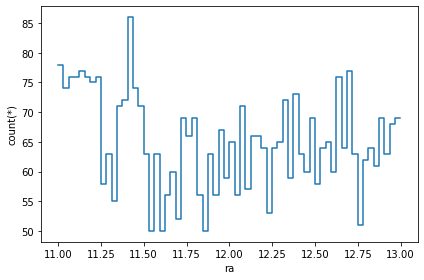

In [41]:
# check the data
tmass = vaex.open_many(glob(join(tmass_data_dir, "*.hdf5")))
tmass.viz.histogram("ra")

In [42]:
tmass

#,ra,dec,j,k,designation,ph_qual,use_src,rd_flg
0,11.000156,-34.379086,15.911,15.031,00440003-3422447,AAB,1,222
1,11.00208,-34.455269,16.007,15.541,00440049-3427189,ABC,1,222
2,11.002762,-34.668907,16.01,14.98,00440066-3440080,AAA,1,222
3,11.00316,-34.744743,15.308,14.42,00440075-3444410,AAA,1,222
4,11.003373,-34.072971,16.143,15.411,00440080-3404226,ACC,1,222
...,...,...,...,...,...,...,...,...
"4,159",12.995733,-33.493195,13.635,13.231,00515897-3329355,AAA,1,222
"4,160",12.995735,-33.672951,14.869,14.439,00515897-3340226,AAA,1,222
"4,161",12.99595,-33.89793,16.168,15.348,00515902-3353525,ACC,1,222
"4,162",12.996678,-33.365849,15.876,15.157,00515920-3321570,ABC,1,222


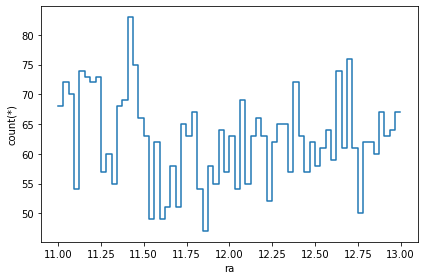

In [43]:
gaia = vaex.open_many(glob(join(gaia_data_dir, "*.hdf5")))
gaia.viz.histogram("ra")

In [44]:
gaia

#,source_id,ra,dec,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,g,bp,rp,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,l,b,tmass_id,j,k,ph_qual,use_src,rd_flg
0,5006000613617348480,12.000475962077937,-34.069343325658345,nan,nan,nan,nan,nan,nan,nan,20.698315,19.004793,17.458633,30.479643,61.362537,nan,11.76973,nan,nan,308.7971153296628,-83.01973493064607,00480011-3404097,16.133,14.936,BBB,1,222
1,5005925464574027648,12.003640026108222,-34.320654634311815,17.09273,14.79353364569145,0.29525915,-8.562287149048096,0.3328816,1.2145172637041746,0.29973266,19.326653,20.664236,18.19406,13.955322,52.419224,1.0302474,1.406235,nan,nan,308.5572335841579,-82.77016701782436,00480082-3419141,16.535,15.594,BBU,1,220
2,5005918871799755776,12.004462402496701,-34.49869117704842,24.27987,-10.926337773629225,0.016928181,-21.682416101688816,0.019475468,3.1664930559344517,0.018302858,12.783537,13.171815,12.230554,1353.5066,3172.65,1.1590643,1.2076706,20.107126,1.6923168,308.40612578566333,-82.59317259997916,00480107-3429549,11.574,11.113,AAA,1,222
3,5005894265931313536,12.009745372236292,-34.823773070966,6.415928,-4.534141609454265,0.06865835,-4.5393489564714695,0.13403375,0.5683489454120091,0.123656765,17.877136,18.358871,17.270817,72.98521,127.87862,0.9660927,1.2011118,nan,nan,308.1250617895592,-82.2701751164736,00480233-3449256,16.314,15.891,BCD,1,222
4,5005921616283297536,12.010099059618875,-34.40476810829329,nan,nan,nan,nan,nan,nan,nan,20.884142,19.518343,17.933954,13.488242,26.016285,nan,8.923625,nan,nan,308.44579992531743,-82.68707317525265,00480243-3424171,16.414,14.867,BCB,1,222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"3,995",5006596372825617536,11.989418810981633,-33.411281185209795,9.451533,-5.293269780841161,0.16276602,-7.830247967166388,0.15892017,0.6842038814650301,0.13880053,18.21406,18.794975,17.555641,43.47655,117.36791,1.000151,1.1966524,nan,nan,309.53588734104653,-83.6722837349411,00475746-3324406,16.949,15.869,CDD,1,222
"3,996",5006622421802710400,11.992757003734987,-33.0889276861141,12.590373,4.136245789024968,0.1423591,-11.891549967532852,0.17914435,0.3743014953645126,0.17100392,18.285034,18.822287,17.622894,64.78428,67.88284,1.0190394,1.2167314,nan,nan,309.8870306726123,-83.99243568882441,00475823-3305192,16.691,15.69,BUU,1,200
"3,997",5006610189735852416,11.99278153766965,-33.13238039975485,42.577003,39.631213703928594,0.021681327,-15.561752515724985,0.02442226,0.7124430327630487,0.025343014,14.325352,14.57544,13.912325,1120.3326,991.6829,1.0351112,1.191791,118.74942,12.110964,309.83381122028834,-83.94934400914104,00475821-3307561,13.434,13.1,AAA,1,222
"3,998",5006596063587971200,11.9928330577061,-33.42599019126854,35.640152,25.81237233537678,0.40919444,-24.575227344568624,0.37384018,2.7653295627642662,0.29987586,19.31142,20.952156,18.063562,8.532091,46.414646,1.1047448,1.4884996,nan,nan,309.4939579899106,-83.65803339506482,00475824-3325330,16.269,15.299,ABC,1,222


Now, we are ready to query the whole data.

It is better to run the code in dedicated python file instead of jupyter notebook. This way, we can run the code in the background. We can also run the code in parallel.

in `/script` directory, run `python gaia-tmass.py (ra_low) (ra_high) (dec_low) (dec_high) [dec_start]` to query the data.
The `(...)` means the argument is required, while `[...]` means the argument is optional.
This will create an array of RA and DEC ranges, with step of 1 degree. The `dec_start` is the starting DEC of the first RA. The default value is -90.
Sometimes we want to continue the last query if something wrong happen.

run `python -u gaia-tmass.py (ra_low) (ra_high) (dec_low) (dec_high) [dec_start] [dec_end] | tee (log-file)` save the std output to `log-file`. The `-u` flag is to make sure the std output is not buffered.